In [47]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers




In [48]:
SEED = 42

path = Path("data/public_dataset.csv")
df = pd.read_csv(path)
y = df["y"].astype(int)          # Series
X = df.drop(columns=["y"])       # DataFrame

# Ratios deseados
train_ratio = 0.60
val_ratio   = 0.20
test_ratio  = 0.20
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9


In [49]:
# 1) separar TEST
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=test_ratio, stratify=y, random_state=SEED
)

# 2) separar TRAIN/VAL desde el resto
rel_val = val_ratio / (1.0 - test_ratio)   # proporción de val dentro de temp
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=SEED
)

print("Shapes:")
print("  train:", X_train.shape)
print("  val  :", X_val.shape)
print("  test :", X_test.shape)

print("\nDistribución (proporciones):")
print("  train:\n", y_train.value_counts(normalize=True).round(3))
print("  val:\n",   y_val.value_counts(normalize=True).round(3))
print("  test:\n",  y_test.value_counts(normalize=True).round(3))

Shapes:
  train: (460, 1280)
  val  : (154, 1280)
  test : (154, 1280)

Distribución (proporciones):
  train:
 y
0    0.785
1    0.215
Name: proportion, dtype: float64
  val:
 y
0    0.786
1    0.214
Name: proportion, dtype: float64
  test:
 y
0    0.786
1    0.214
Name: proportion, dtype: float64


# 1) Límites de outliers con IQR (calculados solo en TRAIN)

Para cada columna calculamos umbrales extremos usando ±3×IQR (más conservador que ±1.5×IQR).

Si una columna no tiene variación (IQR=0), no clippeamos.

¿Por qué solo en TRAIN? Para evitar data leakage: los límites se aprenden con train y se aplican tal cual a val/test/quiz.

In [50]:
#Guardamos el orden exacto de las columnas.

#Mantener el orden es clave para que train/val/test e inferencia alimenten al modelo con los mismos features en la misma posición.
num_cols = X.columns.tolist()

# --- IQR bounds calculados SOLO en TRAIN ---
def iqr_extreme_bounds(s: pd.Series):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return -np.inf, np.inf
    return float(q1 - 3.0*iqr), float(q3 + 3.0*iqr)

clip_bounds = {c: iqr_extreme_bounds(X_train[c]) for c in num_cols}
clip_bounds


{'0': (-0.1481315415, 0.197508722),
 '1': (-3.3103462390000002, 4.46047177925),
 '2': (-0.186483387, 0.24864451599999998),
 '3': (-1.03108047, 1.37477396),
 '4': (-0.6830287275, 0.9107049700000001),
 '5': (-0.16766023874999997, 0.22354698499999998),
 '6': (-2.9120271, 6.1332583624999994),
 '7': (-inf, inf),
 '8': (-0.6473594715, 0.8673045779999999),
 '9': (-3.4003634250000014, 9.719917525000003),
 '10': (-0.0654800295, 0.087306706),
 '11': (-3.4158384500000025, 9.679822100000003),
 '12': (-0.3520149135, 0.469353218),
 '13': (-2.3079510565000003, 3.109890798625),
 '14': (-3.6297810750000004, 8.625659850000002),
 '15': (-1.5821722349999998, 2.3307142075),
 '16': (-2.493656155, 3.4825515825),
 '17': (-inf, inf),
 '18': (-0.3338106825, 0.44508091),
 '19': (-0.0471962205, 0.062928294),
 '20': (-inf, inf),
 '21': (-0.23161106250000002, 0.30881475),
 '22': (-1.7897680900000004, 3.2053986425000005),
 '23': (-inf, inf),
 '24': (-0.391086782, 0.5514052527500001),
 '25': (-inf, inf),
 '26': (-0.2

# 2) Aplicar el clipping con los límites aprendidos

Sustituimos valores extremos por el límite (winsorizing).

Reduce la influencia de outliers en el entrenamiento y estabiliza la optimización del MLP.

In [51]:

def clip_with_bounds(df_in: pd.DataFrame, bounds: dict):
    df_out = df_in.copy()
    for c, (lo, hi) in bounds.items():
        df_out[c] = df_out[c].clip(lower=lo, upper=hi)
    return df_out

X_train_clip = clip_with_bounds(X_train, clip_bounds)
X_val_clip   = clip_with_bounds(X_val,   clip_bounds)
X_test_clip  = clip_with_bounds(X_test,  clip_bounds)

X_test_clip

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
634,0.000000,2.013247,0.010597,0.061597,0.910705,0.017849,2.058289,0.000000,0.163703,2.422755,...,0.453929,0.000778,0.488104,0.0,4.519049,0.000000,0.000000,0.001794,0.000000,2.260857
274,0.142749,0.039572,0.000000,0.000000,0.000000,0.041014,0.518857,0.000000,0.146302,3.479688,...,3.249652,0.000000,0.742966,0.0,1.058152,0.000000,0.047652,0.034166,0.137146,0.180616
232,0.000000,0.427526,0.011019,0.000000,0.324383,0.106006,2.137774,0.012905,0.078323,5.213752,...,1.802655,0.000000,1.156479,0.0,4.262912,0.000000,0.157892,0.000000,0.137146,1.702988
107,0.000000,0.189065,0.248645,0.554901,0.172229,0.000000,2.057117,0.010389,0.000000,4.285076,...,3.324397,0.070436,1.697701,0.0,1.260384,0.000000,0.021227,0.000000,0.000000,1.057209
241,0.000000,1.044452,0.000000,0.000000,0.229530,0.000000,0.922710,0.000000,0.052414,2.586820,...,0.671337,0.000000,0.320128,0.0,1.475554,0.000000,0.000000,0.008828,0.000000,1.048004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,0.000000,1.948158,0.062166,1.113814,0.005685,0.148507,1.002321,0.000000,0.000000,0.572262,...,1.297646,0.088397,0.485492,0.0,1.177728,0.000000,0.157892,0.000000,0.008397,1.108718
617,0.197509,0.893316,0.022562,0.323131,0.000000,0.021897,1.964728,0.043426,0.049994,1.193169,...,2.246198,0.159765,2.179276,0.0,3.577255,0.020466,0.157892,0.000000,0.000000,0.142285
329,0.143083,0.008031,0.000000,0.000000,0.000000,0.014213,0.290430,0.000000,0.310832,3.421613,...,3.634339,0.000000,0.511030,0.0,1.375237,0.000000,0.157892,0.056456,0.137146,0.207354
127,0.000000,0.086113,0.000000,0.000000,0.007679,0.000000,0.817018,0.000989,0.000000,4.060424,...,1.330500,0.000000,1.429233,0.0,1.277243,0.000000,0.000000,0.000000,0.009179,0.635738


# 3) Estandarización con estadísticas de TRAIN

Calculamos media y desviación estándar solo en train_clippeado.

Reemplazamos std=0 por 1 para evitar división por cero (columnas constantes).

eps es un colchón numérico que mejora la estabilidad.

Aplicamos la misma transformación a val/test:

In [52]:
# --- Estandarización con medias/STD de TRAIN ---
eps   = 1e-8
means = X_train_clip[num_cols].mean(axis=0)
stds  = X_train_clip[num_cols].std(axis=0).replace(0.0, 1.0)

def standardize(df_in: pd.DataFrame, means: pd.Series, stds: pd.Series):
    out = df_in.copy()
    out[num_cols] = (out[num_cols] - means) / (stds + eps)
    return out

X_train_std = standardize(X_train_clip, means, stds)
X_val_std   = standardize(X_val_clip,   means, stds)
X_test_std  = standardize(X_test_clip,  means, stds)

X_test_std

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
634,-0.585698,1.575802,-0.504013,-0.506832,2.929653,-0.382191,0.524526,-0.227211,0.151139,-0.621368,...,-1.381131,-0.574492,-0.772759,-0.15018,2.014447,-0.053491,-0.616802,-0.474009,-0.602044,1.352213
274,1.820044,-0.801051,-0.656266,-0.708555,-0.627898,-0.053847,-1.296663,-0.227211,0.050005,0.273439,...,0.933786,-0.588403,-0.398831,-0.15018,-0.887459,-0.053491,0.339546,1.165908,2.475729,-1.021839
232,-0.585698,-0.333847,-0.497956,-0.708555,0.639261,0.867368,0.618558,-0.061849,-0.345082,1.741510,...,-0.264358,-0.588403,0.207867,-0.15018,1.799680,-0.053491,2.552032,-0.564916,2.475729,0.715550
107,-0.585698,-0.621019,2.915971,1.108685,0.044891,-0.635182,0.523139,-0.094088,-0.800286,0.955286,...,0.995676,0.671487,1.001936,-0.15018,-0.717890,-0.053491,-0.190782,-0.564916,-0.602044,-0.021437
241,-0.585698,0.409103,-0.656266,-0.708555,0.268732,-0.635182,-0.818894,-0.227211,-0.495659,-0.482470,...,-1.201113,-0.588403,-1.019209,-0.15018,-0.537474,-0.053491,-0.616802,-0.117678,-0.602044,-0.031942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,-0.585698,1.497416,0.236866,2.939066,-0.605689,1.469777,-0.724713,-0.227211,-0.800286,-2.188009,...,-0.682516,0.992766,-0.776591,-0.15018,-0.787196,-0.053491,2.552032,-0.564916,-0.413606,0.037347
617,2.742906,0.227094,-0.332128,0.349665,-0.627898,-0.324807,0.413840,0.329237,-0.509725,-1.662345,...,0.102905,2.269332,1.708491,-0.15018,1.224768,17.755992,2.552032,-0.564916,-0.602044,-1.065584
329,1.825676,-0.839035,-0.656266,-0.708555,-0.627898,-0.433721,-1.566898,-0.227211,1.006240,0.224272,...,1.252315,-0.588403,-0.739122,-0.15018,-0.621588,-0.053491,2.552032,2.295123,2.475729,-0.991325
127,-0.585698,-0.745003,-0.656266,-0.708555,-0.597902,-0.635182,-0.943931,-0.214539,-0.800286,0.765094,...,-0.655312,-0.588403,0.608045,-0.15018,-0.703754,-0.053491,-0.616802,-0.564916,-0.396059,-0.502436


# 4) Salida lista para Keras
Convertimos a float32 (formato típico y eficiente para redes).

Imprimimos shapes para confirmar coherencia dimensional.

In [53]:
# --- Matrices listas para Keras ---
X_train_ready = X_train_std[num_cols].to_numpy(dtype=np.float32)
X_val_ready   = X_val_std[num_cols].to_numpy(dtype=np.float32)
X_test_ready  = X_test_std[num_cols].to_numpy(dtype=np.float32)

y_train_np = y_train.to_numpy(dtype=int)
y_val_np   = y_val.to_numpy(dtype=int)
y_test_np  = y_test.to_numpy(dtype=int)

print("Dimensiones listas:", X_train_ready.shape, X_val_ready.shape, X_test_ready.shape)


Dimensiones listas: (460, 1280) (154, 1280) (154, 1280)


# Beneficios y consideraciones (concluciones)

* Sin fuga de información: todo (umbrales, medias, std) se aprende en TRAIN y se aplica a VAL/TEST.

* Robustez: el clipping con ±3×IQR atenúa valores aberrantes que desestabilizan el MLP.

* Estabilidad numérica: std.replace(0,1) y eps evitan problemas en columnas constantes o con muy baja varianza.

* Reproducible: si fijas SEED y usas el mismo flujo, obtendrás los mismos splits/transformaciones.

* Alternativas si quieres experimentar:

    - RobustScaler (mediana/IQR) en lugar de Z-score.

    - QuantileTransformer o PowerTransformer si hay colas muy pesadas.

    - Cambiar el umbral de clipping (±2.5×IQR o percentiles 1–99).


# pesos de clase por desbalance

Con 78.5% vs 21.5% puede ayudar a estabilizar entrenamiento

In [54]:
input_dim  = X_train_ready.shape[1]
n_classes  = int(np.unique(y_train_np).size)

classes = np.unique(y_train_np)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_np
)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
class_weight_dict

{0: 0.6371191135734072, 1: 2.323232323232323}

# Reproducibilidad

Fijar semillas reduce la variabilidad entre corridas (mismo split + mismo init ≈ mismas curvas).

In [55]:
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Constructor de los modelos utilizando keras

Qué hace: construye y compila un MLP en Keras a partir de un diccionario de hiperparámetros cfg.

Arquitectura mínima pero potente (2 capas ReLU), regularización combinada (L2 + Dropout), optimizador moderno (AdamW) y una loss adecuada a etiquetas enteras. Todo parametrizado vía cfg para reusar en entrenamiento base y tuning.

In [56]:
def build_mlp_cfg(cfg, input_dim, n_classes):
    """Crea el MLP a partir de un diccionario cfg."""
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(cfg["hidden1"], activation="relu",
                     kernel_regularizer=regularizers.l2(cfg["wd"])),
        layers.Dropout(cfg["drop1"]),
        layers.Dense(cfg["hidden2"], activation="relu",
                     kernel_regularizer=regularizers.l2(cfg["wd"])),
        layers.Dropout(cfg["drop2"]),
        layers.Dense(n_classes, activation="softmax"),
    ])
    opt = optimizers.AdamW(learning_rate=cfg["lr"], weight_decay=cfg["wd"])
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


# Callbacks

* EarlyStopping: corta entrenamiento cuando deja de mejorar (y restaura el mejor estado).

* ReduceLROnPlateau: baja el LR para escapar mesetas sin reiniciar entrenamiento.

* ModelCheckpoint (opcional): guarda en disco el mejor modelo durante el training

* Qué hace: crea los callbacks que controlan el entrenamiento.

* En síntesis: control automático del entrenamiento para evitar sobreentrenar y ajustar LR cuando se estanca, sin intervención manual.

In [57]:

def make_callbacks(pat_es=15, pat_rlr=6, monitor="val_loss"):
    """Devuelve EarlyStopping y ReduceLROnPlateau configurados."""
    es  = callbacks.EarlyStopping(monitor=monitor, patience=pat_es,
                                  restore_best_weights=True, verbose=0)
    rlr = callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.5,
                                      patience=pat_rlr, min_lr=1e-6, verbose=0)
    return [es, rlr]


# Entrenador
* Entrena con validación en cada época, class_weight para el desbalance y callbacks para control del proceso.

* Qué hace: entrena el modelo y calcula un conjunto de métricas de validación relevantes (incluyendo métricas para desbalance).

* Binario vs. multiclase:

    - Binario: usa val_probs[:, 1] como prob. de la clase positiva → ROC-AUC y Average Precision (PR-AUC) bien definidas.

    - Multiclase: calcula AUC-ROC macro (ovo) y AP macro; promedia el rendimiento en todas las clases.

* Métricas devueltas:

    - val_loss: model.evaluate(...)[0]. Criterio principal de selección (umbral-independiente y estable).
    - val_acc: exactitud general (útil, pero puede ser engañosa con desbalance).
    - val_f1: balancea precision y recall; binary para 0/1 o macro si multiclase.
    - val_auc: calidad de ranking (probabilidades); clave con desbalance.
    - val_ap: área bajo la curva precisión–recobrado; muy informativa para clase minoritaria.
    - epochs_ran: número de épocas efectivas (diagnóstico de early stopping y ritmo de convergencia).

* Por qué este set de métricas:

    - val_loss para seleccionar modelos de manera robusta.
    - F1 / AUC / AP porque tu problema está desbalanceado; miden mejor la utilidad práctica que la accuracy sola.
    - Mantener probabilidades permite inspección posterior (umbralización distinta, curvas, etc.).

In [58]:

def train_and_eval(model, Xtr, ytr, Xva, yva, batch, epochs, class_weight, cbs):
    """Entrena y evalúa en validación. Devuelve (history, metrics_dict)."""
    hist = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=epochs,
        batch_size=batch,
        class_weight=class_weight,
        callbacks=cbs,
        verbose=0,
    )
    # predicciones y métricas val
    val_probs = model.predict(Xva, verbose=0)
    val_pred  = val_probs.argmax(axis=1)

    # binario vs multiclase
    if val_probs.shape[1] == 2:
        val_p1 = val_probs[:, 1]
        val_auc = roc_auc_score(yva, val_p1)
        val_ap  = average_precision_score(yva, val_p1)
        avg = "binary"
    else:
        val_auc = roc_auc_score(yva, val_probs, multi_class="ovo", average="macro")
        val_ap  = average_precision_score(yva, val_probs, average="macro")
        avg = "macro"

    metrics = {
        "val_loss": float(model.evaluate(Xva, yva, verbose=0)[0]),
        "val_acc":  float(accuracy_score(yva, val_pred)),
        "val_f1":   float(f1_score(yva, val_pred, average=avg)),
        "val_auc":  float(val_auc),
        "val_ap":   float(val_ap),
        "epochs_ran": len(hist.history.get("loss", [])),
    }
    return hist, metrics

In [59]:
def plot_history(hist, smooth_k=None, show_acc=True, figsize=(6,4)):
    """
    Grafica curvas de entrenamiento a partir de un History de Keras.
    - smooth_k: tamaño de ventana para suavizar (media móvil). None = sin suavizado.
    - show_acc: si True, intenta graficar accuracy (si existe en el history).
    """

    def smooth(x, k):
        if k is None or k <= 1 or len(x) < k: 
            return x
        w = np.ones(k)/k
        return np.convolve(x, w, mode="valid")

    H = hist.history
    epochs = range(1, len(H.get("loss", [])) + 1)

    # --- Loss ---
    train_loss = H.get("loss", [])
    val_loss   = H.get("val_loss", [])

    plt.figure(figsize=figsize)
    plt.plot(epochs[:len(smooth(train_loss, smooth_k))] if smooth_k else epochs,
             smooth(train_loss, smooth_k), label="Train loss")
    if val_loss:
        plt.plot(epochs[:len(smooth(val_loss, smooth_k))] if smooth_k else epochs,
                 smooth(val_loss, smooth_k), label="Val loss")
    plt.xlabel("Época"); plt.ylabel("Pérdida (loss)")
    ttl = "Curva de pérdida por época"
    if smooth_k and smooth_k > 1: ttl += f" (smooth k={smooth_k})"
    plt.title(ttl); plt.legend(); plt.tight_layout(); plt.show()

    # --- Accuracy (si existe y si show_acc=True) ---
    if show_acc:
        train_acc = H.get("accuracy", []) or H.get("acc", [])
        val_acc   = H.get("val_accuracy", []) or H.get("val_acc", [])
        if train_acc:
            plt.figure(figsize=figsize)
            plt.plot(epochs[:len(smooth(train_acc, smooth_k))] if smooth_k else epochs,
                     smooth(train_acc, smooth_k), label="Train acc")
            if val_acc:
                plt.plot(epochs[:len(smooth(val_acc, smooth_k))] if smooth_k else epochs,
                         smooth(val_acc, smooth_k), label="Val acc")
            plt.xlabel("Época"); plt.ylabel("Accuracy")
            ttl = "Curva de accuracy por época"
            if smooth_k and smooth_k > 1: ttl += f" (smooth k={smooth_k})"
            plt.title(ttl); plt.legend(); plt.tight_layout(); plt.show()


# Entrenamiento “base”

* Definir una configuración base de hiperparámetros
    - Capas densas de 512 → 256 neuronas: capacidad suficiente para tabular con muchos features.
    - Dropout 0.2 + L2 (wd=1e-4): regularización combinada para frenar overfitting.
    - AdamW, lr=1e-3: tasa de aprendizaje segura/estándar; weight decay coherente con la L2 de las capas.
    - batch=128: equilibrio típico entre estabilidad y velocidad.
    - epochs=200 con EarlyStopping (pat_es=15) y ReduceLROnPlateau (pat_rlr=6): entrenas “hasta que deje de mejorar” sin quedarte corto ni sobreentrenar.
* Construiste el modelo con esa config
    - Creacion del modelo base utilizando el helper build_mlp_cfg para crear el MLP (misma arquitectura y optimizador, pero parametrizados con BASE_CFG).
* Crear los callbacks con esa config
    - EarlyStopping + ReduceLROnPlateau con las paciencias definidas en BASE_CFG.
* Entrenar y Evaluar en validación, devolviendo métricas
    - Entrenas con class_weight (corrige el desbalance 78/22).
    - train_and_eval te devuelve:
        - hist_base: historia de entrenamiento (loss/accuracy por época).
        - metrics_base: val_loss, val_acc, val_f1, val_auc, val_ap, epochs_ran.
* Imprimir las métricas base
    - Da un punto de referencia (baseline) antes del tuning. Sirve para saber si el tuning realmente mejora.

# Concluciones

* Baseline sólido y reproducible: una config razonable y estable para comparar contra las variantes del tuning.
* Reuso sin duplicación: usas build_mlp_cfg, make_callbacks, train_and_eval para que el entrenamiento base y el tuning compartan exactamente la misma lógica.
* Regularización balanceada (Dropout + L2 + AdamW) con control del proceso (EarlyStopping + ReduceLR) → menor riesgo de overfitting en tabular con muchas columnas.
* Métricas adecuadas para desbalance (además de accuracy, miras F1, ROC-AUC y PR-AUC).

In [60]:
# Hiperparámetros base (tu config original)
BASE_CFG = {
    "hidden1": 512, "hidden2": 256,
    "drop1": 0.2, "drop2": 0.2,
    "lr": 1e-3, "wd": 1e-4,
    "batch": 128, "epochs": 200,
    "pat_es": 15, "pat_rlr": 6,
}

model_base = build_mlp_cfg(BASE_CFG, input_dim, n_classes)
cbs_base   = make_callbacks(BASE_CFG["pat_es"], BASE_CFG["pat_rlr"])
hist_base, metrics_base = train_and_eval(
    model_base,
    X_train_ready, y_train_np,
    X_val_ready,   y_val_np,
    batch=BASE_CFG["batch"], epochs=BASE_CFG["epochs"],
    class_weight=class_weight_dict, cbs=cbs_base
)
print("Métricas base (val):", metrics_base)


Métricas base (val): {'val_loss': 0.3842492699623108, 'val_acc': 0.9285714285714286, 'val_f1': 0.8405797101449275, 'val_auc': 0.9679439018281994, 'val_ap': 0.8773932776283819, 'epochs_ran': 102}


# Tuning ligero (random search) sin repetir nada

* nicialización del muestreador
    - Qué: Crea un generador de números aleatorios con semilla fija.
    - Por qué: Hace el tuning reproducible: si vuelves a correr, obtienes las mismas configuraciones en el mismo orden.

* Espacio de búsqueda y nº de pruebas
    - Qué: Defines rangos discretos para cada hiperparámetro:
        - H1/H2: tamaño de las dos capas densas.
        - DR: dropout por capa (controla overfitting).
        - LR: learning rate de AdamW.
        - WD: weight decay (L2).
        - BS: batch size.
        - N_TRIALS: nº de configuraciones a evaluar.
    - Por qué: Rangos razonables para tabular; un random search pequeño (12) cubre el espacio sin costo excesivo (80/20).
* Muestreo de una configuración
    - Qué: Toma una combinación al azar de cada lista y fija también épocas y “paciencias”.
    - Por qué: Mantiene constantes los “timers” (EarlyStopping/ReduceLR) y explora lo más sensible: capacidad, regularización, LR y batch.
* ucle de experimentos
    - Qué: Para cada “trial”:
        -Construye el modelo con la misma función que usas en entrenamiento normal → nada de duplicación.
        -Crea los callbacks con las paciencias de la config.
        -Entrena y evalúa en validación con train_and_eval, que ya computa val_loss, val_acc, val_f1, val_auc, val_ap.
    - Por qué: Garantiza que tuning y entrenamiento base usan idéntico pipeline (justo lo que querías: reusar helpers).
* Registro de resultados y selección del mejor
    - Qué:
        - Guarda hiperparámetros + métricas de cada trial en results.
        - Actualiza best si la val_loss mejora.
    - Por qué:
        - Trazabilidad: podrás comparar, ordenar, justificar la elección.
        - Criterio robusto: val_loss es menos dependiente de umbrales y estable; si te interesa priorizar minoritaria, puedes cambiar el criterio a val_f1/val_ap/val_auc.
* Tabla ordenada y reporte
    - Qué:
        - Crea un DataFrame, lo ordena por val_loss y muestra el Top 5 más la mejor configuración y sus métricas.
    - Por qué:
        - Vista rápida para decidir si te quedas con la ganadora por val_loss o prefieres otra con mejor F1/AP (según objetivos del taller).

In [61]:
rng = np.random.default_rng(42)

# Espacio de búsqueda
H1, H2 = [256, 512], [128, 256]
DR, LR, WD, BS = [0.1, 0.2, 0.3], [3e-4, 1e-3, 3e-3], [1e-5, 1e-4, 3e-4], [64, 128, 256]
N_TRIALS = 12

def sample_cfg():
    return {
        "hidden1": int(rng.choice(H1)),
        "hidden2": int(rng.choice(H2)),
        "drop1":   float(rng.choice(DR)),
        "drop2":   float(rng.choice(DR)),
        "lr":      float(rng.choice(LR)),
        "wd":      float(rng.choice(WD)),
        "batch":   int(rng.choice(BS)),
        "epochs":  200,
        "pat_es":  15, "pat_rlr": 6,
    }

results, best = [], None

for t in range(N_TRIALS):
    cfg = sample_cfg()
    model_t = build_mlp_cfg(cfg, input_dim, n_classes)
    cbs     = make_callbacks(cfg["pat_es"], cfg["pat_rlr"])
    hist_t, m = train_and_eval(
        model_t, X_train_ready, y_train_np,
        X_val_ready, y_val_np,
        batch=cfg["batch"], epochs=cfg["epochs"],
        class_weight=class_weight_dict, cbs=cbs
    )

    row = {"trial": t, **cfg, **m}
    results.append(row)
    if (best is None) or (m["val_loss"] < best["metrics"]["val_loss"]):
        best = {"trial": t, "cfg": cfg, "metrics": m, "model": model_t, "history": hist_t}

res_df = pd.DataFrame(results).sort_values("val_loss").reset_index(drop=True)
print("\nTop 5 por val_loss:")
print(res_df[["trial","hidden1","hidden2","drop1","drop2","lr","wd","batch",
              "val_loss","val_acc","val_f1","val_auc","val_ap","epochs_ran"]].head(5).to_string(index=False))

print("\nMejor cfg:", best["cfg"])
print("Métricas val:", best["metrics"])



Top 5 por val_loss:
 trial  hidden1  hidden2  drop1  drop2    lr      wd  batch  val_loss  val_acc   val_f1  val_auc   val_ap  epochs_ran
     5      256      256    0.3    0.1 0.001 0.00001    256  0.256771 0.915584 0.805970 0.957175 0.869036          26
     0      256      256    0.2    0.2 0.001 0.00030     64  0.288793 0.928571 0.835821 0.977711 0.918034         100
     7      512      256    0.1    0.2 0.001 0.00010     64  0.312911 0.922078 0.823529 0.967944 0.909147          20
     3      256      128    0.3    0.3 0.001 0.00010    256  0.315237 0.889610 0.738462 0.950413 0.837062          23
    11      256      256    0.3    0.3 0.001 0.00001    256  0.348760 0.883117 0.727273 0.942149 0.862279          39

Mejor cfg: {'hidden1': 256, 'hidden2': 256, 'drop1': 0.3, 'drop2': 0.1, 'lr': 0.001, 'wd': 1e-05, 'batch': 256, 'epochs': 200, 'pat_es': 15, 'pat_rlr': 6}
Métricas val: {'val_loss': 0.2567710280418396, 'val_acc': 0.9155844155844156, 'val_f1': 0.8059701492537313, 'val_au

# Entrenamiento final (con la mejor cfg)
* Unir TRAIN + VAL para el entrenamiento final
    - Aprovechas todos los datos disponibles para ajustar los pesos finales (salvo TEST).
* Usar la mejor config del tuning
* Entrenar
* Evaluar en TEST


Epoch 1: val_loss improved from None to 1.91176, saving model to models/mlp_best.keras

Epoch 2: val_loss improved from 1.91176 to 0.29230, saving model to models/mlp_best.keras

Epoch 3: val_loss improved from 0.29230 to 0.12711, saving model to models/mlp_best.keras

Epoch 4: val_loss improved from 0.12711 to 0.10019, saving model to models/mlp_best.keras

Epoch 5: val_loss did not improve from 0.10019

Epoch 6: val_loss did not improve from 0.10019

Epoch 7: val_loss improved from 0.10019 to 0.09844, saving model to models/mlp_best.keras

Epoch 8: val_loss improved from 0.09844 to 0.05146, saving model to models/mlp_best.keras

Epoch 9: val_loss improved from 0.05146 to 0.02923, saving model to models/mlp_best.keras

Epoch 10: val_loss improved from 0.02923 to 0.02145, saving model to models/mlp_best.keras

Epoch 11: val_loss improved from 0.02145 to 0.01844, saving model to models/mlp_best.keras

Epoch 12: val_loss improved from 0.01844 to 0.01803, saving model to models/mlp_best.

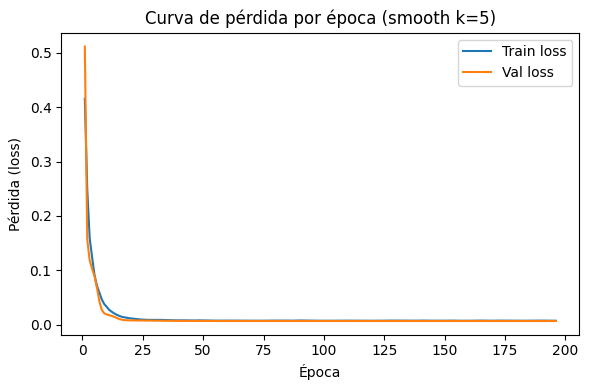

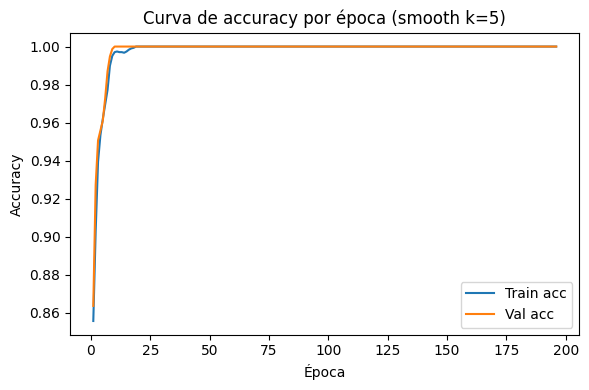

In [62]:
# --- 1) Combinar TRAIN + VAL para entrenar final (sigues usando val para ES/monitor) ---
X_trfinal = np.vstack([X_train_ready, X_val_ready])
y_trfinal = np.concatenate([y_train_np, y_val_np])

final_cfg   = best["cfg"]  # o BASE_CFG si prefieres
model_final = build_mlp_cfg(final_cfg, input_dim, n_classes)

# --- 2) Callback para guardar el "mejor" según val_loss ---
os.makedirs("models", exist_ok=True)

# Opción A: guardar TODO el modelo (recomendado para re-cargar sin reconstruir)
best_model_path = "models/mlp_best.keras"
ckpt = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,   # guarda modelo completo
    verbose=1
)

# (si prefieres SOLO pesos, usa:)
# best_weights_path = "models/mlp_best.weights.h5"
# ckpt = ModelCheckpoint(
#     filepath=best_weights_path,
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,   # guarda solo pesos
#     verbose=1
# )

# --- 3) Callbacks finales: EarlyStopping/ReduceLR + checkpoint ---
cbs_final = make_callbacks(final_cfg["pat_es"], final_cfg["pat_rlr"])
cbs_final = cbs_final + [ckpt]

# --- 4) Entrenamiento final ---
hist_final, _ = train_and_eval(
    model_final, X_trfinal, y_trfinal,
    X_val_ready, y_val_np,             # validación para ES/monitor
    batch=final_cfg["batch"], epochs=final_cfg["epochs"],
    class_weight=class_weight_dict, cbs=cbs_final
)

# --- 5) Cargar el MEJOR estado antes de evaluar en TEST ---
# Si guardaste modelo completo:
model_final = load_model(best_model_path)

# (Si guardaste solo pesos, entonces:)
# model_final.load_weights(best_weights_path)

# --- 6) Evaluación en TEST + curvas ---
test_loss, test_acc = model_final.evaluate(X_test_ready, y_test_np, verbose=0)
print(f"[TEST] loss={test_loss:.4f} acc={test_acc:.4f}")

plot_history(hist_final, smooth_k=5, show_acc=True)


# Ploteo de metiricas
* Elegir el modelo a evaluar
    - Qué:
        - apuntas al modelo sobre el que quieres medir desempeño en TEST.
    - Por qué:
        - si ya reentrenaste con TRAIN+VAL, lo lógico es evaluar model_final. Si aún no, best["model"] (el mejor del tuning) también sirve.
    
* Probabilidades y clases predichas en TEST
    - Qué:
        - obtienes probabilidades por clase (softmax) y luego la clase predicha con argmax.
    - Por qué:
        - muchas métricas (ROC-AUC, PR-AUC) necesitan probabilidades; para la matriz de confusión necesitas las clases discretas.
*Matriz de confusión
    - Qué: creas la matriz [filas = verdad, columnas = predicho] en el orden fijo [0, 1].
    - Por qué: fija el orden de etiquetas evita confusiones y hace la matriz comparable entre corridas.
        - cm[0,0]: verdaderos negativos (TN)
        - cm[0,1]: falsos positivos (FP)
        - cm[1,0]: falsos negativos (FN)
        - cm[1,1]: verdaderos positivos (VP)
* Matriz normalizada por filas
    - Qué:
        - normalizas cada fila para que la suma sea 1.
    - Por qué:
        - cada fila representa los casos reales de una clase; al normalizar por filas obtienes el recall/sensibilidad por clase (qué % de una clase real fue bien identificado).
* Gráfico de la matriz de confusión
    - Qué y por qué:
        - plt.imshow(cm): muestra la matriz como heatmap simple para leer patrones visualmente (dónde se concentra el error).
        - xticks/yticks: etiquetas claras para ejes (Pred vs True) y clases (0,1).
        - plt.text(...): pone el conteo exacto en cada celda → lectura inmediata sin calcular mentalmente.
        - tight_layout(): evita que los textos se corten.
        - show(): renderiza la figura.

Matriz de confusión (conteos) [rows=verdad, cols=pred]:
 [[120   1]
 [  7  26]]

Matriz de confusión normalizada por filas (recall por clase):
 [[0.992 0.008]
 [0.212 0.788]]

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.945     0.992     0.968       121
           1      0.963     0.788     0.867        33

    accuracy                          0.948       154
   macro avg      0.954     0.890     0.917       154
weighted avg      0.949     0.948     0.946       154



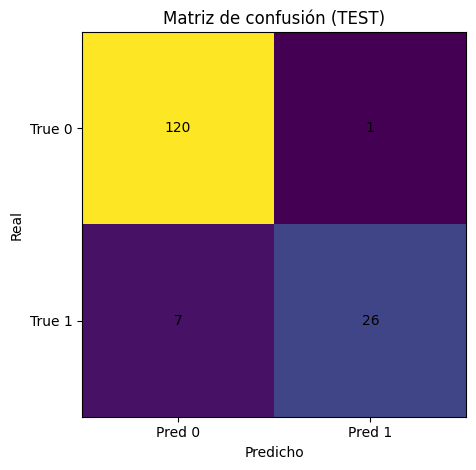

In [63]:

# usa el modelo final; si no lo tienes, puedes usar best["model"]
mdl = model_final  # o: mdl = best["model"]

# predicción en TEST
test_probs = mdl.predict(X_test_ready, verbose=0)
y_test_pred = np.argmax(test_probs, axis=1)

# matriz de confusión (conteos)
cm = confusion_matrix(y_test_np, y_test_pred, labels=[0,1])
print("Matriz de confusión (conteos) [rows=verdad, cols=pred]:\n", cm)

# matriz normalizada por filas (recalls)
cm_norm = confusion_matrix(y_test_np, y_test_pred, labels=[0,1], normalize="true")
print("\nMatriz de confusión normalizada por filas (recall por clase):\n", np.round(cm_norm, 3))

# reporte completo por si lo necesitas
print("\nClassification report (TEST):")
print(classification_report(y_test_np, y_test_pred, digits=3))

fig = plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (TEST)")
plt.xticks([0,1], ["Pred 0","Pred 1"])
plt.yticks([0,1], ["True 0","True 1"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()


# Qué hicimos (Concluciones)

* Montamos un random search pequeño sobre hiperparámetros clave del MLP (anchos de capas, dropout, LR, weight decay y batch size).

* Entrenamos cada configuración con EarlyStopping y ReduceLROnPlateau, usando class_weight para compensar el desbalance 78/22.

* Seleccionamos el mejor modelo por val_loss y registramos métricas complementarias (accuracy, F1, ROC-AUC, PR-AUC) en validación.

# Beneficios

* Eficiencia: pocas corridas bien elegidas → mejoras reales sin gastar tiempo excesivo (principio de 80/20).

* Robustez: EarlyStopping + ReduceLROnPlateau evitan sobreentrenar y ajustan el LR de forma adaptativa.

* Mejor sensibilidad a la minoritaria: class_weight reduce el sesgo hacia la clase mayoritaria; junto a F1/PR-AUC permite evaluar utilidad real.

* Sin fuga de información: tuning sólo con train/val; el test queda intacto para estimar generalización al final.

* Trazabilidad: res_df conserva hiperparámetros y métricas por trial → fácil comparar y justificar la elección.

# Lo que revelan las métricas (cómo leerlas)

* val_loss: criterio principal estable y menos dependiente del umbral; minimiza error global.

* val_auc y val_ap: capturan ranking y calidad en clase positiva; útiles con desbalance.

* val_f1: balancea precision/recall; si sube cuando accuracy no, indica mejor trato de la minoritaria.

* epochs_ran: si la mayoría corta temprano, el modelo puede estar sobre-capacitado o el LR alto; si corre muchas épocas sin bajar, quizá hace falta más capacidad o LR más alto.

# Consideraciones / riesgos

* Sobreajuste de hiperparámetros a la validación: por eso dejamos test virgen para el informe final.

* Variabilidad estocástica: con redes pequeñas, la semilla importa; si dos configs son muy cercanas, puedes re-correr la mejor 2–3 veces para confirmar.

* LR/WD extremos: LR muy alto puede oscilar; WD muy alto puede infra-ajustar. Mantenerlos en rangos razonables (p. ej., LR ∈ [3e-4, 3e-3], WD ∈ [1e-5, 3e-4]) es prudente.

* Dropout excesivo: >0.4 en tabular suele empeorar; 0.1–0.3 es un “sweet spot” típico.